In [1]:
import os
import numpy as np
import pandas as pd
import sys
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import peakutils
sns.set()

In [2]:
#função para dar dataframe de coverage
def getDataCSVs(data_name, filepath):
    listcsv = glob.glob(data_name)
    mt = re.compile(r'(.*)\.(.*)\.(.*)')
    flist = ()
    for inst in listcsv:
        flist += ([inst,int(mt.sub(r'\2',inst))],)
    listcsv = sorted(flist, key = lambda x: x[1])
    slist = [el[0] for el in listcsv]
    data = pd.read_csv(slist[0])
    for i, el in enumerate(slist[1:]):
        data = pd.concat([data,pd.read_csv(el)])
        

    folders = []
    for i in range(0,10):
        folders += glob.glob(str(i)+'*')
        
    folders2 = []
    for i in range(0,10):
        folders2 += glob.glob('*.csv')
    folders2.append('0.orgg')
    
    folders3 = set(folders) - set(folders2)
    
    time = sorted([float(l) for l in folders3])
    #print(time)
    data['time'] = time[0:len(data)]
    data.fillna(value = 0, inplace = True) #deals with NaN values by filling them with zeros since they are too low
    return data

In [5]:
modelcentered_model_list = ['centered','2c','3c','4c','5c','7c','8c','9c','10c'] #all model numbers for the centered patterns
modelcentered2_model_list = ['centered','2c2','3c2','4c2','5c2','7c2','8c2','9c2','10c2'] #all model numbers for the centered patterns
modeldiagonal_model_list = ['diagonal','1d','2d','3d','4d','5d','7d','8d','9d','10d'] #all model numbers for the diagonal patterns
modeldiagonal2_model_list = ['diagonal','1d2','2d2','3d2','4d2','5d2','7d2','8d2','9d2','10d2'] #all model numbers for the diagonal patterns


In [4]:
#stores all data from models specified in list parameters
def getAllData(modeltypelist, modellist, lstmod, thresholdslist):
    for tmodel in modeltypelist:
        for nmodel in modellist[1:]:    

            folder = "/home/caio/models/model"+modellist[0]
            if (nmodel[-1] != '2'):
                filepath = '/model' + nmodel[:-1] + '/model' + nmodel[:-1] +"_"+tmodel+"/"
            else:
                filepath = '/model' + nmodel[:-2] + '/model' + nmodel[:-2] +"_"+tmodel+"/"
            os.chdir(folder + filepath)

            #Create all data frames from .csv files
            for threshold in thresholdslist:
                lstmod['df_' + nmodel + '_' + tmodel + '_' + str(threshold)] = getDataCSVs(nmodel+'volthr'+str(threshold)+'.*.csv', filepath)    

In [49]:
lst = {}                      # dict for all models with all thresholds
thresholds = list(range(0,5)) # thresholds in mol/L                 #type of model

getAllData('1',modeldiagonal_model_list, lst, thresholds) #gets all data from diagonal models type 1
getAllData('1',modelcentered_model_list, lst, thresholds) #gets all data from centered models type 1
getAllData('2',modelcentered2_model_list, lst, thresholds) #gets all data from diagonal models type 2
getAllData('2',modeldiagonal2_model_list, lst, thresholds) #gets all data from diagonal models type 2

In [29]:
#Defines preprocessing function to be used in the next cell
def preprocessing(dtframe, alllabels, threshold):
    #Dropping unnecessary columns from DF
    dtframe.drop(labels = alllabels, axis = 1, inplace = True)
    #Renames Con and Vol columns
    dtframe.rename(columns={
                    'Con': 'Con_' + threshold,
                    'Volume': 'Volume_' + threshold
                }, inplace = True)

In [30]:
def buildFinalDataFrame(modeltype, modellist, dfs_dict):
    #Preprocessing DFs
    for nmodel in modellist[1:]: 
        #Average magnitude of velocity U per time for the model
        if not set(['U']).issubset(lst['df_' + nmodel + '_'+ modeltype +'_1'].columns):
            lst['df_' + nmodel + '_'+ modeltype +'_1']['U'] = np.sqrt(
                np.power(np.array(lst['df_' + nmodel + '_'+ modeltype +'_1']['U:0']),2) + 
                np.power(np.array(lst['df_' + nmodel + '_'+ modeltype +'_1']['U:1']),2) + 
                np.power(np.array(lst['df_' + nmodel + '_'+ modeltype +'_1']['U:2']),2)) 
            #Finishes preprocessing
            preprocessing(lst['df_' + nmodel + '_'+ modeltype +'_1'], ['U:0','U:1','U:2','Cell Type'], '1')
            # creates model final DF
            dfs_dict['df_' + nmodel + '_'+ modeltype] = lst['df_' + nmodel + '_'+ modeltype +'_1'].copy() 

            #Drops redundant columns, renames remaining columns and merges
            #dfs into a single df under the corresponding model key
            for key, df in list(lst.items()):
                if (key[4] == 'c' or key[4] == 'd'):
                    if key[5] != '2':
                        if (key[-1] != '1' and key[3:5] == nmodel):
                            #Preprocesses and merges df with the final model DF
                            preprocessing(df, ['U:0','U:1','U:2','p','Cell Type'], key[-1])
                            dfs_dict['df_' + nmodel + '_'+ modeltype] = dfs_dict['df_' + nmodel + '_'+ modeltype].merge(df, how='inner', on='time')
                    else:
                        if (key[-1] != '1' and key[3:6] == nmodel):
                            #Preprocesses and merges df with the final model DF
                            preprocessing(df, ['U:0','U:1','U:2','p','Cell Type'], key[-1])
                            dfs_dict['df_' + nmodel + '_'+ modeltype] = dfs_dict['df_' + nmodel + '_'+ modeltype].merge(df, how='inner', on='time')
                else: # unfortunately, model 10 is a special case, it has 2 digits and we need this extra code chunk
                    if key[6] != '2':
                        if (key[-1] != '1' and key[3:6] == nmodel):
                            #Preprocesses and merges df with the final model DF
                            preprocessing(df, ['U:0','U:1','U:2','p','Cell Type'], key[-1])
                            dfs_dict['df_' + nmodel + '_'+ modeltype] = dfs_dict['df_' + nmodel + '_'+ modeltype].merge(df, how='inner', on='time')
                    else:
                        if (key[-1] != '1' and key[3:7] == nmodel):
                            #Preprocesses and merges df with the final model DF
                            preprocessing(df, ['U:0','U:1','U:2','p','Cell Type'], key[-1])
                            dfs_dict['df_' + nmodel + '_'+ modeltype] = dfs_dict['df_' + nmodel + '_'+ modeltype].merge(df, how='inner', on='time')

In [74]:
inletdf = pd.read_csv('inletFlowRateVectors.csv')

In [78]:
inletcp = inletdf.copy()
inletcp.set_index('model', inplace=True)

In [87]:
av = np.sqrt(np.dot(inletcp.loc['2c1'],inletcp.loc['2c1']))

In [88]:
av

2.407631577795309e-10

In [50]:
#Assigning the total volume value to a variable
voltot = 7.5/1000000

In [51]:
dfs_cent = {} #final preprocessed DFs, each key refers to one model
dfs_cent2 = {}
dfs_diag = {}
dfs_diag2 = {}
buildFinalDataFrame('1', modeldiagonal_model_list, dfs_diag)
buildFinalDataFrame('2', modeldiagonal2_model_list, dfs_diag2)
buildFinalDataFrame('1', modelcentered_model_list, dfs_cent)
buildFinalDataFrame('2', modelcentered2_model_list, dfs_cent2)

In [52]:
#creates time index in hours
for df in dfs_cent.values():
    df['time_hours'] = df['time']/3600
    df.drop(labels='time', axis = 1, inplace = True)
    
for df in dfs_cent2.values():
    df['time_hours'] = df['time']/3600
    df.drop(labels='time', axis = 1, inplace = True)
    
for df in dfs_diag.values():
    df['time_hours'] = df['time']/3600
    df.drop(labels='time', axis = 1, inplace = True)
    
for df in dfs_diag2.values():
    df['time_hours'] = df['time']/3600
    df.drop(labels='time', axis = 1, inplace = True)
#   df.set_index('time_seconds', inplace = True)

In [53]:
#dfplot = dfs_final['df_2c_1']
dfplot = pd.DataFrame()
for df in list(dfs_cent.values()):
    dfplot = pd.concat([dfplot, df], ignore_index=True)
    
dfplot2 = pd.DataFrame()
for df in list(dfs_cent2.values()):
    dfplot2 = pd.concat([dfplot2, df], ignore_index=True)
    
dfplotdiag = pd.DataFrame()
for df in list(dfs_diag.values()):
    dfplotdiag = pd.concat([dfplotdiag, df], ignore_index=True)
    
dfplotdiag2 = pd.DataFrame()
for df in list(dfs_diag2.values()):
    dfplotdiag2 = pd.concat([dfplotdiag2, df], ignore_index=True)

In [54]:
dfs_cent['df_10c_1']

,Con_1,Volume_1,p,U,Con_3,Volume_3,Con_2,Volume_2,Con_0,Volume_0,Con_4,Volume_4,time_hours
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000007,0.000000e+00,0.000000e+00,0.000000
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.957440e-10,0.000007,0.000000e+00,0.000000e+00,0.000139
2,2.848000e-10,1.412500e-10,2.824400e-14,1.754501e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.398820e-10,0.000007,0.000000e+00,0.000000e+00,0.000278
3,7.213800e-10,2.741400e-10,5.482100e-14,2.957403e-14,0.000000e+00,0.000000e+00,1.494600e-10,4.856000e-11,1.584020e-09,0.000007,0.000000e+00,0.000000e+00,0.000417
4,1.249000e-09,4.467700e-10,8.933300e-14,4.753006e-14,0.000000e+00,0.000000e+00,5.763000e-10,1.650700e-10,2.223430e-09,0.000007,0.000000e+00,0.000000e+00,0.000556
5,1.715800e-09,5.693700e-10,1.138400e-13,6.006508e-14,2.824400e-10,6.902700e-11,8.213600e-10,2.147300e-10,2.858610e-09,0.000007,0.000000e+00,0.000000e+00,0.000694
6,2.171700e-09,6.969700e-10,1.393300e-13,7.513216e-14,5.449600e-10,1.270000e-10,1.261900e-09,3.288200e-10,3.490390e-09,0.000007,0.000000e+00,0.000000e+00,0.000833
7,2.628900e-09,8.132500e-10,1.625600e-13,8.763318e-14,8.152000e-10,1.844600e-10,1.759100e-09,4.510800e-10,4.119470e-09,0.000007,4.649600e-11,1.004800e-11,0.000972
8,3.232500e-09,9.864600e-10,1.971700e-13,1.024702e-13,1.069400e-09,2.404800e-10,2.199000e-09,5.587400e-10,4.746400e-09,0.000007,3.013800e-10,6.401800e-11,0.001111
9,3.746100e-09,1.111800e-09,2.222000e-13,1.139003e-13,1.408800e-09,3.163900e-10,2.592500e-09,6.481500e-10,5.371580e-09,0.000007,4.588500e-10,9.610700e-11,0.001250


In [55]:
for thrsh in range(0,5):
    dfplot['Vol_'+str(thrsh)] = dfplot['Volume_'+str(thrsh)]/voltot
    dfplot.drop(labels='Volume_'+str(thrsh), axis=1, inplace = True)
    
for thrsh in range(0,5):
    dfplot2['Vol_'+str(thrsh)] = dfplot2['Volume_'+str(thrsh)]/voltot
    dfplot2.drop(labels='Volume_'+str(thrsh), axis=1, inplace = True)
    
for thrsh in range(0,5):
    dfplotdiag['Vol_'+str(thrsh)] = dfplotdiag['Volume_'+str(thrsh)]/voltot
    dfplotdiag.drop(labels='Volume_'+str(thrsh), axis=1, inplace = True)
    
for thrsh in range(0,5):
    dfplotdiag2['Vol_'+str(thrsh)] = dfplotdiag2['Volume_'+str(thrsh)]/voltot
    dfplotdiag2.drop(labels='Volume_'+str(thrsh), axis=1, inplace = True)

In [56]:
columns = ['Con_' + str(i) for i in range(0,5)] + ['U','p','Vol_0']
dfplot.drop(labels=columns, axis=1, inplace = True)
dfplot2.drop(labels=columns, axis=1, inplace = True)
dfplotdiag.drop(labels=columns, axis=1, inplace = True)
dfplotdiag2.drop(labels=columns, axis=1, inplace = True)

In [57]:
dfplot.head()

,time_hours,Vol_1,Vol_2,Vol_3,Vol_4
0,0.000000,0.000000,0.000000,0.0,0.0
1,0.000139,0.000000,0.000000,0.0,0.0
2,0.000278,0.000017,0.000000,0.0,0.0
3,0.000417,0.000039,0.000008,0.0,0.0
4,0.000556,0.000055,0.000023,0.0,0.0


In [58]:
dfplot.set_index('time_hours', inplace=True)
dfplot2.set_index('time_hours', inplace=True)
dfplotdiag.set_index('time_hours', inplace=True)
dfplotdiag2.set_index('time_hours', inplace=True)

In [60]:
cd ../../..

/home/caio/models


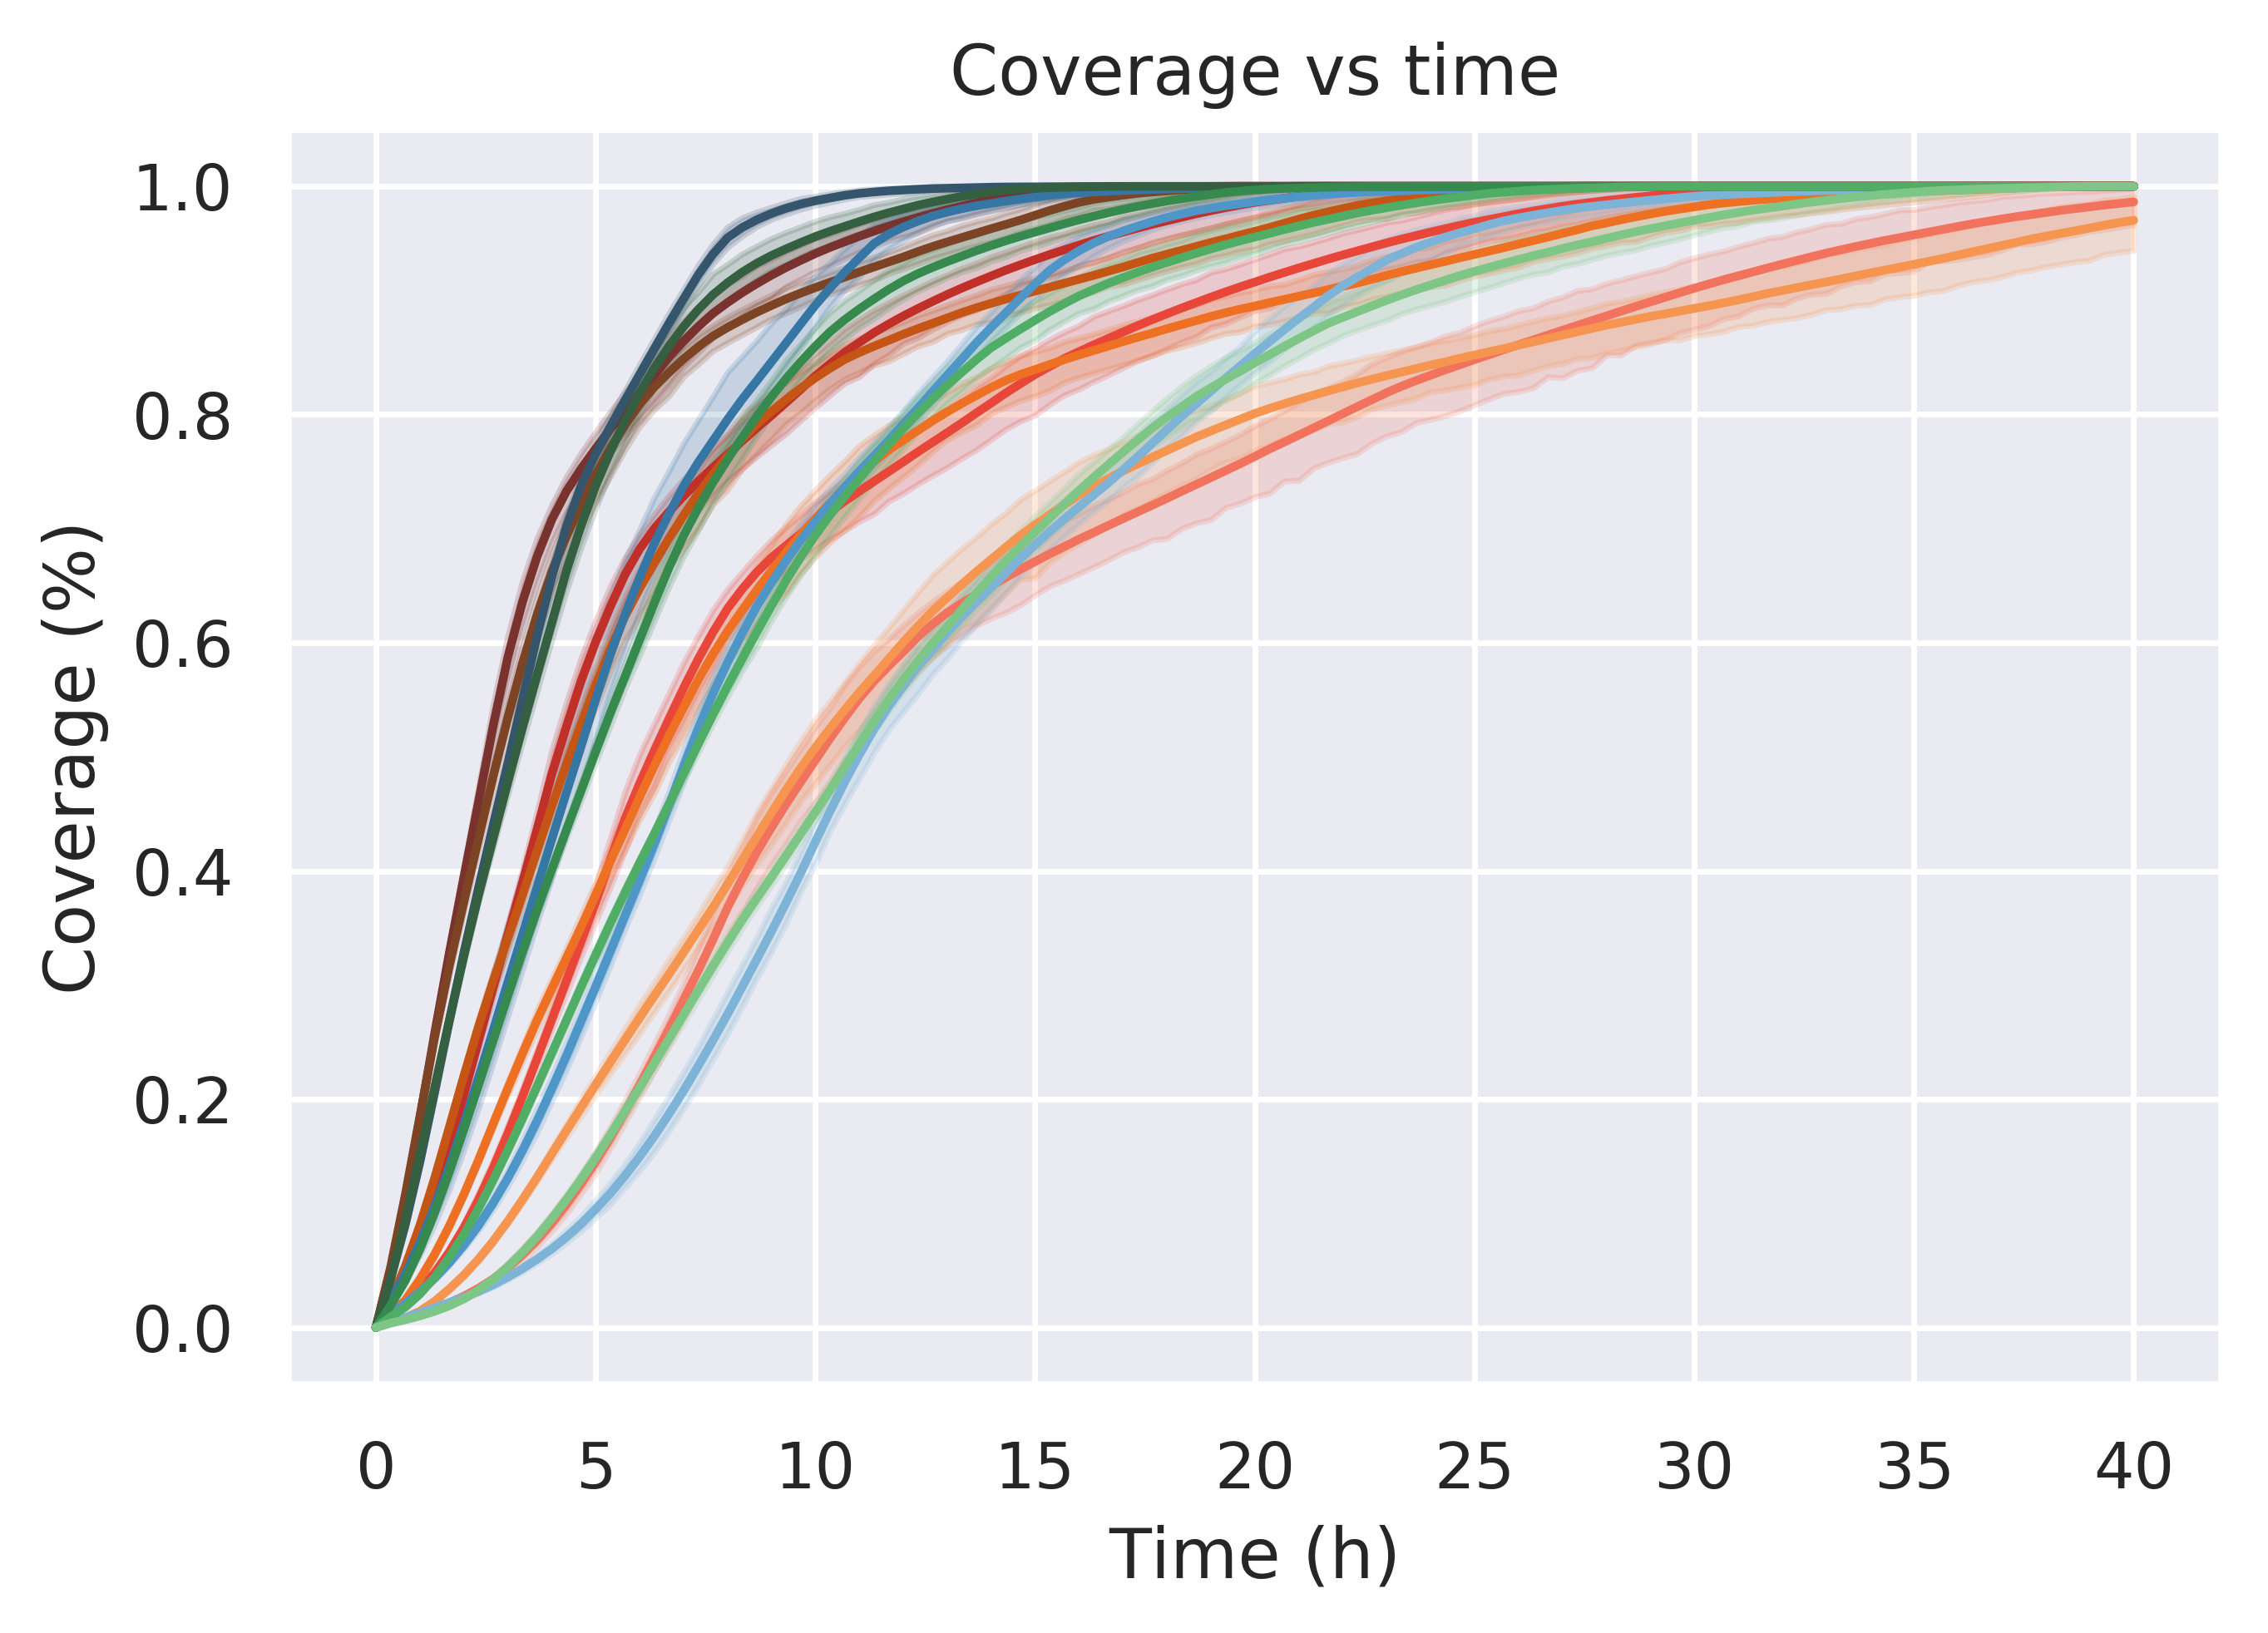

In [63]:
#plot total
fig = plt.figure(dpi=500)

#plot do threshold
#plt.hlines(0.75, dfplot['time_hours'].iloc[0], dfplot['time_hours'].iloc[-1], linestyle=':', color='black', linewidth=1.5)

#plot de cada dado
#sns.lineplot(data=dfplot, palette="Reds_d", dashes=False, legend='brief')
sns.lineplot(data=dfplot, palette="Reds_d", dashes=False, legend=False)

sns.lineplot(data=dfplot2, palette="Oranges_d", dashes=False,legend=False)

# for thrsh in range(1,5):    
sns.lineplot(data=dfplotdiag, palette="Blues_d", dashes=False, legend=False)
#plt.plot(df_final['Volume_' + str(thrsh)]/voltot, linestyle='-', linewidth=2.0, label = "Threshold = " + str(thrsh))

sns.lineplot(data=dfplotdiag2, palette="Greens_d", dashes=False, legend=False)


#label e eixos
plt.title('Coverage vs time')
plt.xlabel('Time (h)')
plt.ylabel('Coverage (%)')
#plt.legend([j + 'threshold = '+str(i)+' mol/L' for j in ['Centered model with ', 'Diagonal model with '] for i in range(1,5)],loc='lower right', shadow=False, fontsize='x-small')
plt.show()
fig.savefig(fname = "teste1.png", dpi = 300)

In [199]:
def func(x, a, b):
    return (-1) * np.exp(- (x - b) / a) + 1

def func2(x, d, e):
    return d * np.power(x, 2) + e * x

def func3(x, a, b):
    return a * pow(x,2) + b

def func4(x, a, b, c, d, e, f, g):
    return a * np.exp(-b * x) + c * np.exp(-d * x) + e * np.exp(-f * x) + g

In [1]:
t = 8
time3 = data1['time'].loc[data1['time']>t*3600]/3600
vol3 = data3['Volume'].loc[data3['time']>t*3600]/voltot
popt3, pcov3 = curve_fit(func, time3, vol3)
time2 = data1['time'].loc[data1['time']<t*3600]/3600
vol2 = data3['Volume'].loc[data3['time']<t*3600]/voltot
popt2, pcov2 = curve_fit(func2, time2, vol2)
t = 41
time = data1['time'].loc[data1['time']<t*3600]/3600
vol = data1['Volume']/voltot
vol = vol.values
popt, pcov = curve_fit(func, time, data1['Volume'].loc[data1['time']<t*3600]/voltot)

NameError: name 'data1' is not defined

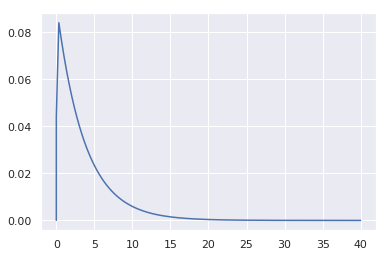

In [99]:
volexp = func(time, *popt)
plt.plot(time, np.gradient(volexp))
plt.show()

df_3c_1
23    1.002778
37    5.669444
Name: time_hours, dtype: float64
26    2.002778
34    4.669444
47    9.002778
Name: time_hours, dtype: float64
31     3.669444
37     5.669444
41     7.002778
51    10.336111
57    12.336111
60    13.336111
Name: time_hours, dtype: float64
38     6.002778
43     7.669444
50    10.002778
67    15.669444
70    16.669444
73    17.669444
80    20.002778
85    21.669444
94    24.669444
Name: time_hours, dtype: float64


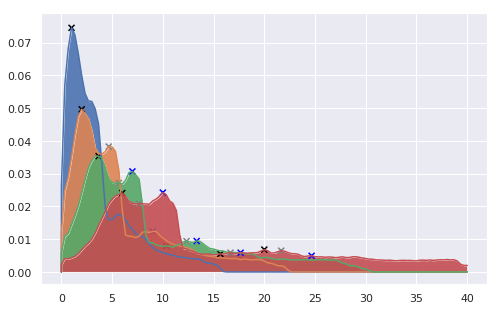

df_2c_1
23    1.002778
28    2.669444
39    6.336111
Name: time_hours, dtype: float64
26    2.002778
33    4.336111
49    9.669444
Name: time_hours, dtype: float64
33     4.336111
38     6.002778
53    11.002778
63    14.336111
Name: time_hours, dtype: float64
44     8.002778
47     9.002778
62    14.002778
87    22.336111
Name: time_hours, dtype: float64


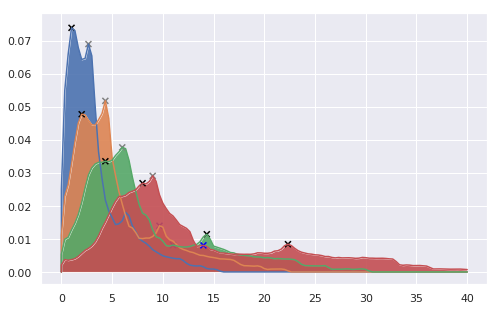

df_9c_1
23    1.002778
26    2.002778
Name: time_hours, dtype: float64
31     3.669444
35     5.002778
43     7.669444
52    10.669444
Name: time_hours, dtype: float64
36     5.336111
41     7.002778
54    11.336111
66    15.336111
Name: time_hours, dtype: float64
42     7.336111
45     8.336111
50    10.002778
61    13.669444
64    14.669444
67    15.669444
71    17.002778
74    18.002778
77    19.002778
88    22.669444
Name: time_hours, dtype: float64


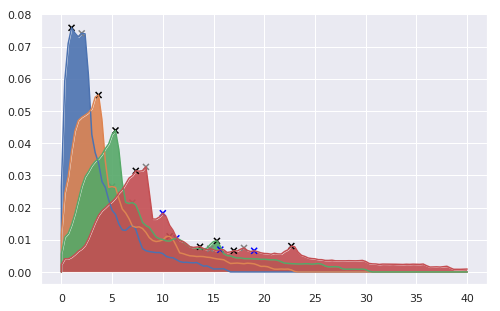

df_7c_1
23    1.002778
28    2.669444
42    7.336111
Name: time_hours, dtype: float64
24     1.336111
32     4.002778
36     5.336111
45     8.336111
48     9.336111
54    11.336111
Name: time_hours, dtype: float64
26     2.002778
29     3.002778
34     4.669444
37     5.669444
44     8.002778
54    11.336111
58    12.669444
62    14.002778
66    15.336111
71    17.002778
78    19.336111
Name: time_hours, dtype: float64
30      3.336111
33      4.336111
39      6.336111
45      8.336111
51     10.336111
56     12.002778
66     15.336111
70     16.669444
75     18.336111
82     20.669444
87     22.336111
92     24.002778
97     25.669444
104    28.002778
108    29.336111
Name: time_hours, dtype: float64


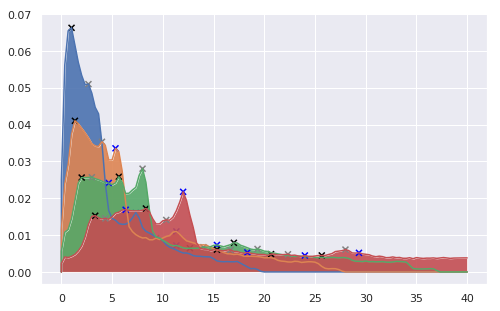

df_10c_1
23    1.002778
27    2.336111
Name: time_hours, dtype: float64
27    2.336111
31    3.669444
34    4.669444
48    9.336111
Name: time_hours, dtype: float64
33     4.336111
36     5.336111
41     7.002778
58    12.669444
61    13.669444
Name: time_hours, dtype: float64
39     6.336111
43     7.669444
52    10.669444
64    14.669444
77    19.002778
83    21.002778
Name: time_hours, dtype: float64


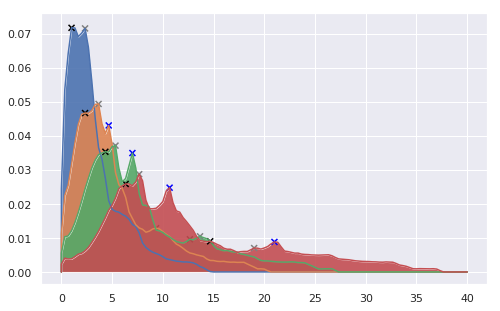

df_4c_1
23    1.002778
28    2.669444
37    5.669444
Name: time_hours, dtype: float64
28     2.669444
32     4.002778
45     8.336111
51    10.336111
Name: time_hours, dtype: float64
36     5.336111
52    10.669444
56    12.002778
64    14.669444
Name: time_hours, dtype: float64
43     7.669444
47     9.002778
52    10.669444
56    12.002778
65    15.002778
70    16.669444
75    18.336111
85    21.669444
88    22.669444
Name: time_hours, dtype: float64


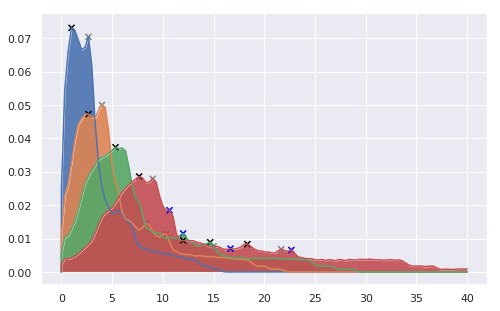

df_5c_1
23    1.002778
28    2.669444
35    5.002778
Name: time_hours, dtype: float64
26     2.002778
31     3.669444
42     7.336111
45     8.336111
50    10.002778
Name: time_hours, dtype: float64
32    4.002778
36    5.336111
Name: time_hours, dtype: float64
43     7.669444
49     9.669444
56    12.002778
Name: time_hours, dtype: float64


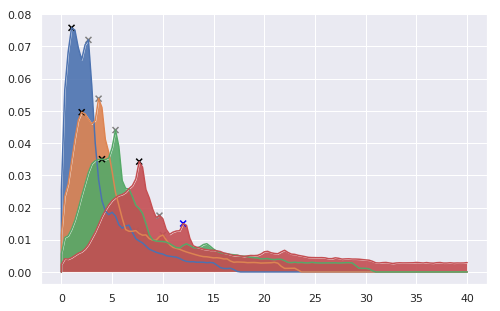

df_8c_1
24    1.336111
27    2.336111
39    6.336111
Name: time_hours, dtype: float64
31    3.669444
49    9.669444
Name: time_hours, dtype: float64
35     5.002778
42     7.336111
50    10.002778
60    13.336111
Name: time_hours, dtype: float64
43     7.669444
51    10.336111
56    12.002778
80    20.002778
Name: time_hours, dtype: float64


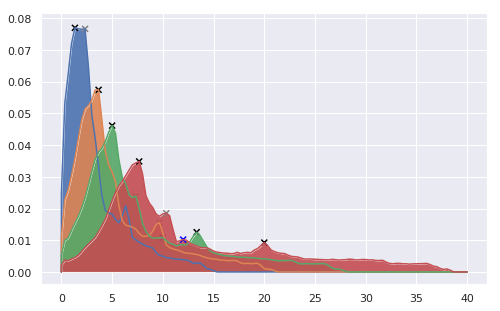

In [33]:
#maxTimeGrad = []

time = dfs_cent['df_3c_1']['time_hours']
for key in dfs_cent.keys():
    print(key)
    fig = plt.figure(figsize=(8,5))
    for thrsh in range(1,5):
        cov = dfs_cent[key]['Volume_'+str(thrsh)]/voltot    
        #maxTimeGrad += [time.iloc[np.argmax(np.gradient(vol))]]
        gradcov = np.gradient(cov)
        plt.fill_between(time, gradcov, alpha=0.9)
        indexes = peakutils.indexes(gradcov, thres=0.2, min_dist=2)
        print(time[indexes])
        plt.scatter(time[indexes], gradcov[indexes], c=['black','gray','blue'] , marker='x')
        plt.plot(time, gradcov)
    plt.show()


In [79]:
#time.iloc[np.argmax(np.gradient(vol))]
#times = time.iloc[np.argpartition(np.gradient(vol),-2)[-2:]]
#np.gradient(vol)

In [84]:
#maxTimeGrad[3] = times.iloc[0]

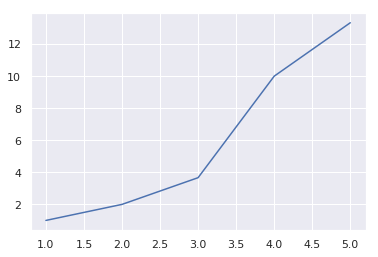

In [101]:
plt.plot([i+1 for i in range(0,5)], maxTimeGrad)
plt.show()

In [102]:
1/popt3[1]
1/popt[1]

42.55756111996147

[3.64667751 0.02349759] 
 [[ 5.71537784e-04 -5.65277913e-05]
 [-5.65277913e-05  5.94574865e-05]] 
 [0.02390686 0.00771087]
[8.16056039 0.57773098] 
 [[ 0.03357702 -0.04661422]
 [-0.04661422  0.07291224]] 
 [0.18324032 0.27002266]


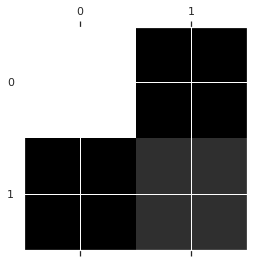

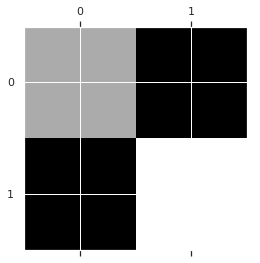

In [103]:
#plt.plot(time, func(time, *popt), 'm', linestyle ='--')
#plt.show()
#popt3
perr = np.sqrt(np.diag(pcov))
perr3 = np.sqrt(np.diag(pcov3))
print(popt, '\n', pcov, '\n', perr)
print(popt3, '\n', pcov3, '\n', perr3)
plt.matshow(pcov, cmap = plt.cm.gray)
plt.show()
plt.matshow(pcov3, cmap = plt.cm.gray)
plt.show()

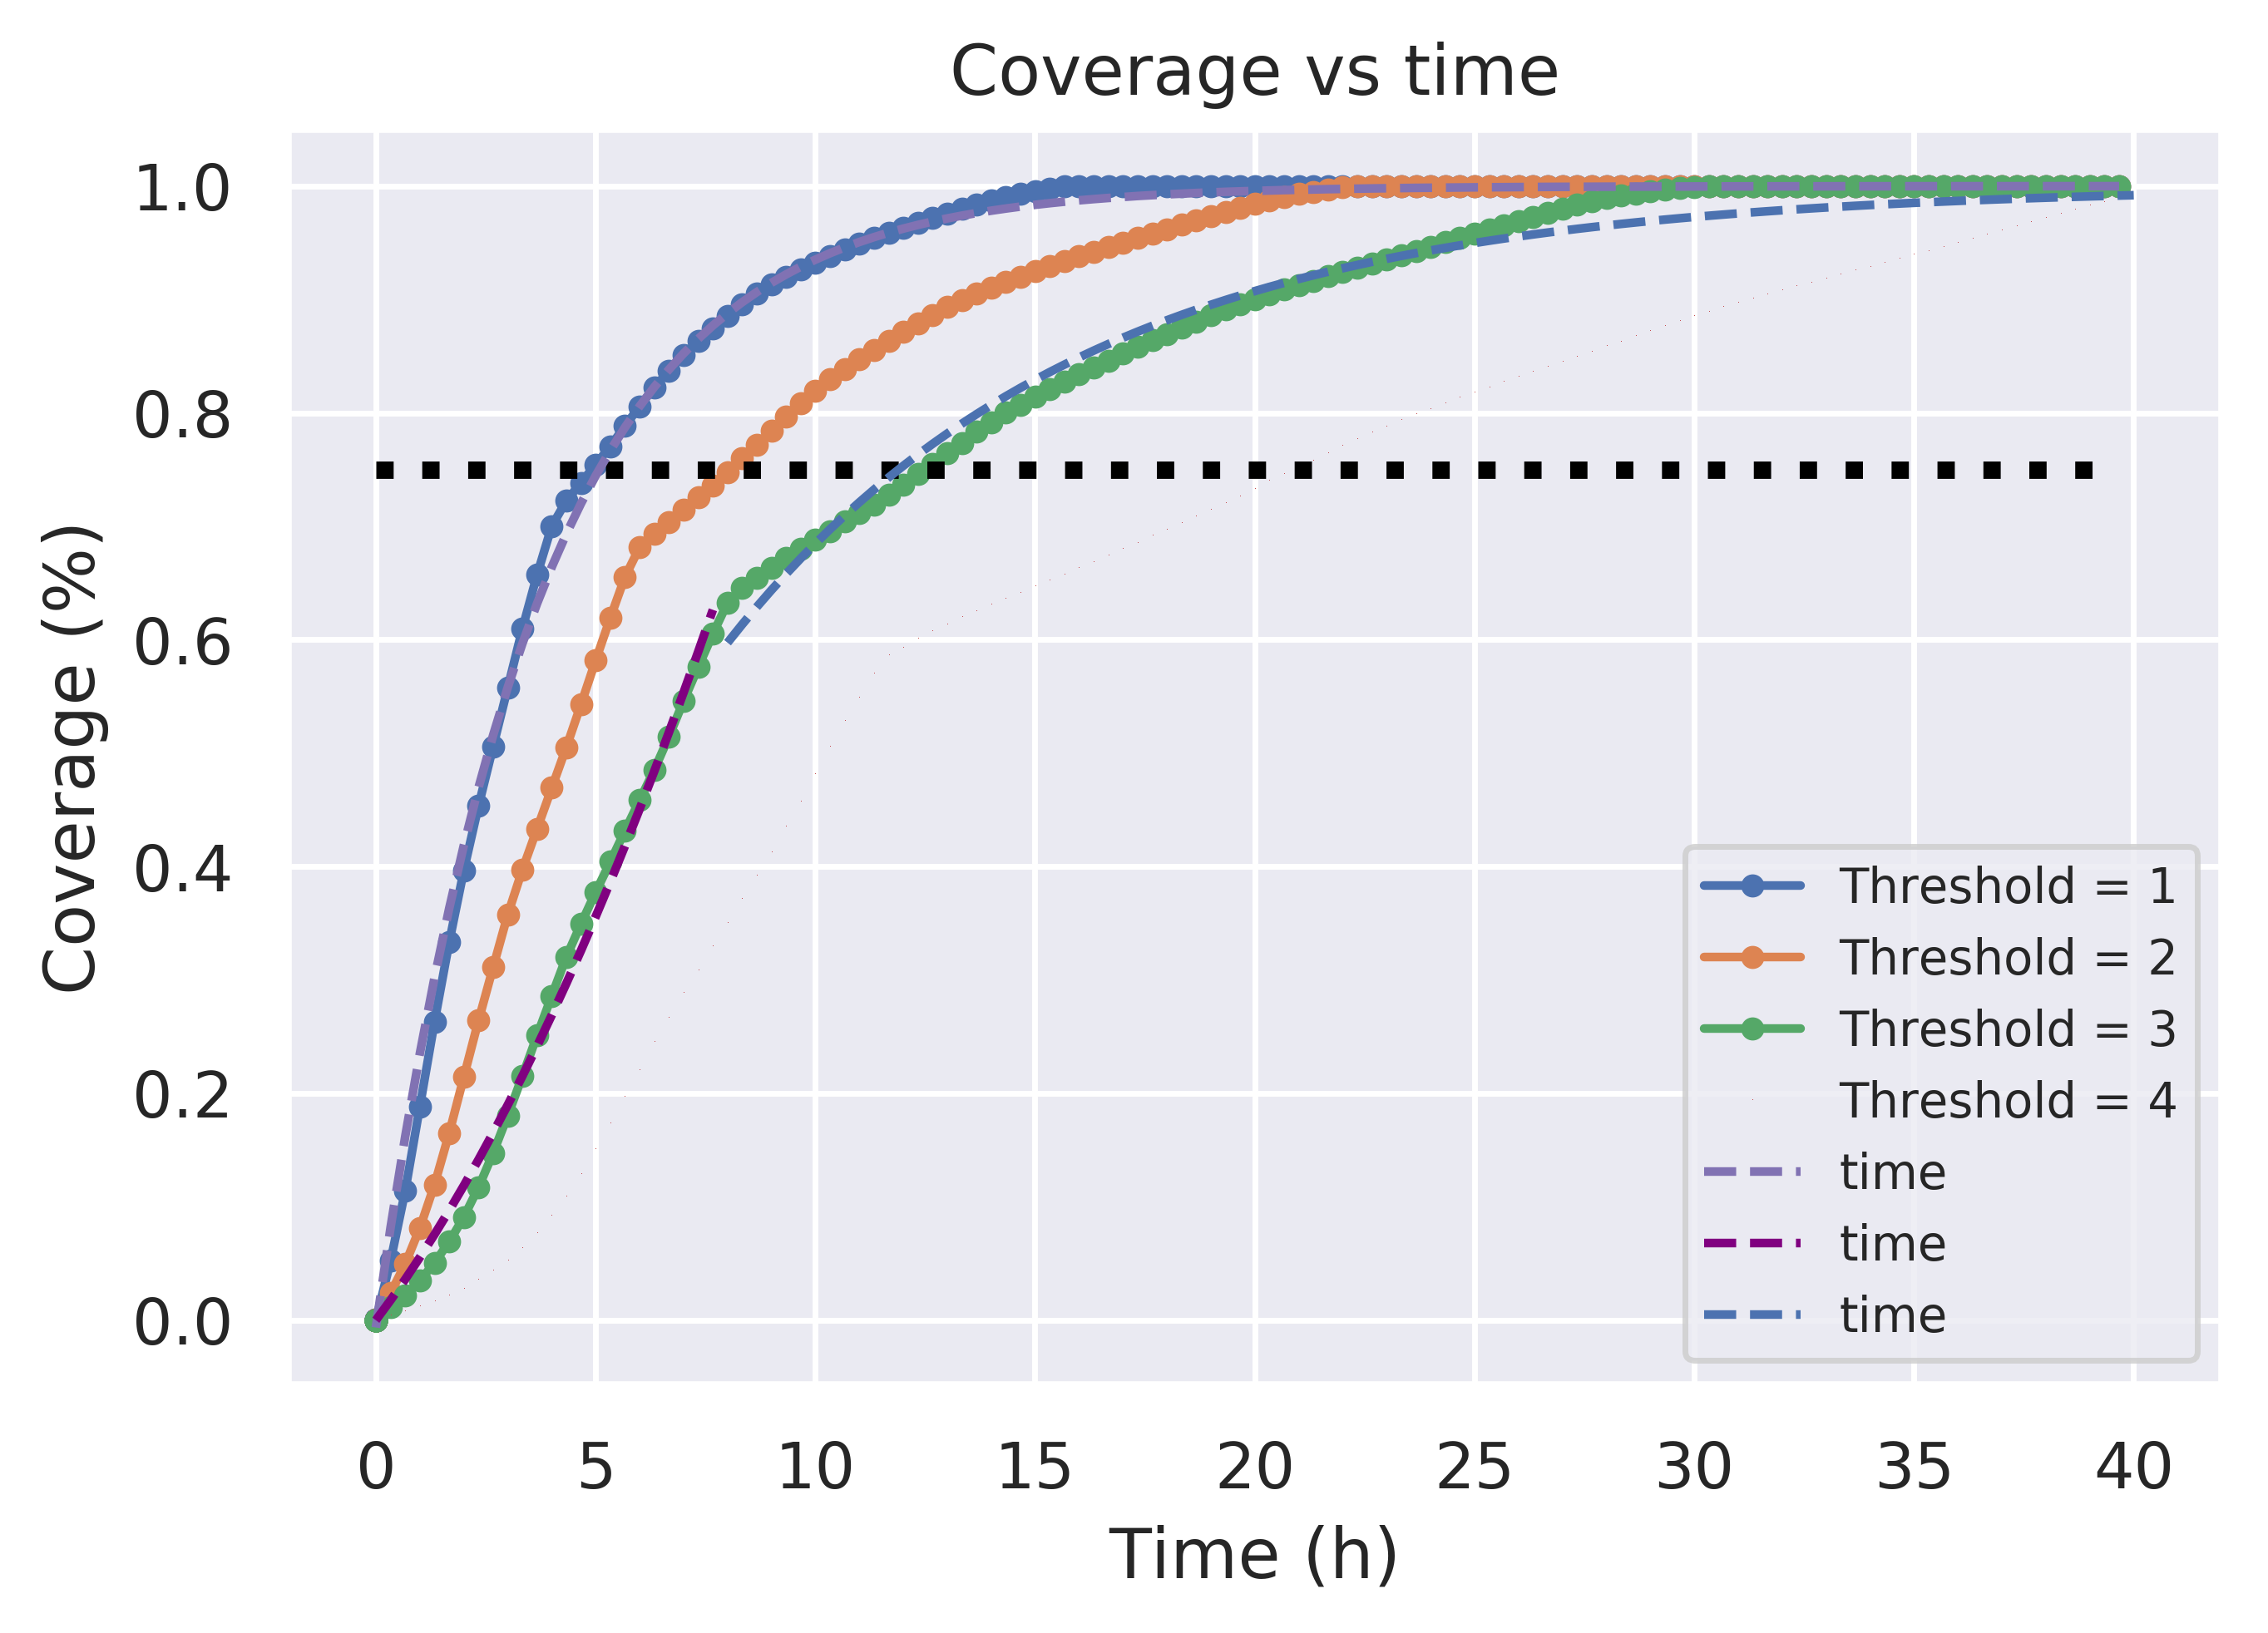

In [15]:
#Plot abaixo de um certo tempo t
sns.set()

t = int(40)
fig = plt.figure(dpi = 500)
ref2 = [0.75 for x in range(len(data1['time'].loc[data1['time']<t*3600]))]

#time = data1['time'].loc[data1['time']<t*3600]/3600

#plot de cada dado
plt.plot(time,data1['Volume'].loc[data1['time']<t*3600]*1000000/7.5, '.-', label = "Threshold = 1")
plt.plot(time,data2['Volume'].loc[data2['time']<t*3600]*1000000/7.5, '.-', label = "Threshold = 2")
plt.plot(time,data3['Volume'].loc[data3['time']<t*3600]*1000000/7.5, '.-', label = "Threshold = 3")
plt.plot(time,data4['Volume'].loc[data4['time']<t*3600]*1000000/7.5, ',', label = "Threshold = 4")
plt.plot(time, ref2, linestyle=':', color='black', linewidth=3)
#constant = 3.8
#expo = 1-np.exp(-(data1['time'].loc[data1['time']<t*3600]/3600)/constant)

plt.plot(time, func(time, *popt), 'm', linestyle ='--')

plt.plot(time2, func2(time2, *popt2), 'purple', linestyle ='--')
plt.plot(time3, func(time3, *popt3), 'b', linestyle ='--')
#plt.plot(time2, func2(time2, lin_reg.coef_[1], lin_reg.coef_[0]), 'purple', linestyle ='--')

#expo = 1-np.exp(-(data1['time'].loc[data1['time']<t*3600]/3600-3)/constant)
#time = data1['time'].loc[data1['time']<t*3600]/3600
#plt.plot(time, expo, 'r', linestyle ='--', (1,0))


#label e eixos
plt.title('Coverage vs time')
plt.xlabel('Time (h)')
plt.ylabel('Coverage (%)')
plt.legend(loc='lower right', shadow=False, fontsize='x-small')
plt.show()
#fig.savefig(fname = "demo", dpi = 500)

In [14]:
t = 8
X = data1['time'].loc[data1['time']<t*3600]/3600
X = X.values
X = np.array(X).reshape(-1,1)
y = data3['Volume'].loc[data3['time']<t*3600]*1000000/7.5
y = y.values

#from sklearn.linear_model import LinearRegression
#lin_reg = LinearRegression()
#lin_reg.fit(X,y)
#print(lin_reg.intercept_, lin_reg.coef_)

In [124]:
#from sklearn.preprocessing import PolynomialFeatures
#poly_features = PolynomialFeatures(degree = 2, include_bias = False)
#X_poly = poly_features.fit_transform(X)

#lin_reg.fit(X_poly, y)
#print(lin_reg.intercept_, lin_reg.coef_)

In [126]:
#popt2

In [125]:
#popt3